In [8]:
!pip install networkx matplotlib
%matplotlib inline

In [2]:
import pandas as pd

# Load the CSV file
file_path = './ilv.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the data to understand its structure
data.head()


,Transaction Hash,Blockno,UnixTimestamp,DateTime (UTC),From,From_PrivateTag,To,To_PrivateTag,Quantity,Method
0,0x2f5d14c501fc1e83ce54626b93091fe22a18786a91b9...,19801252,1714880183,2024-05-05 03:36:23,0x6bd2814426f9a6abaa427d2ad3fc898d2a57adc6,-,0x5014dc84df2b541d84a482610043e596bc659bf4,-,"6,013.84564422958160832",Unlock
1,0x488e7b5e1a7f324ea9a75a8ba7156a7e81190a52a640...,19861176,1715604275,2024-05-13 12:44:35,0x6bd2814426f9a6abaa427d2ad3fc898d2a57adc6,-,0x98f9fabaa629c9c2dd74a43244916faee8552f57,-,125,Unlock
2,0xbb2ccbbc087fcb61cc66b77698ae6e9537af347114bb...,19861181,1715604335,2024-05-13 12:45:35,0x6bd2814426f9a6abaa427d2ad3fc898d2a57adc6,-,0x98f9fabaa629c9c2dd74a43244916faee8552f57,-,0.930883282121973375,Claim Revenue Distribution
3,0x9007c5061225daf94514032bfcbffc75a91ed49801aa...,19886071,1715905139,2024-05-17 00:18:59,0x6bd2814426f9a6abaa427d2ad3fc898d2a57adc6,-,0x2b064e8a1ec1f741437f08ddc8b733fbd790b268,-,385.509589041092702976,Unlock
4,0x4df8e62cb6794b30c914bc472c9af4d27efaa9032b99...,19895357,1716017447,2024-05-18 07:30:47,0x6bd2814426f9a6abaa427d2ad3fc898d2a57adc6,-,0x5014dc84df2b541d84a482610043e596bc659bf4,-,"6,148.928464720314038016",Unlock


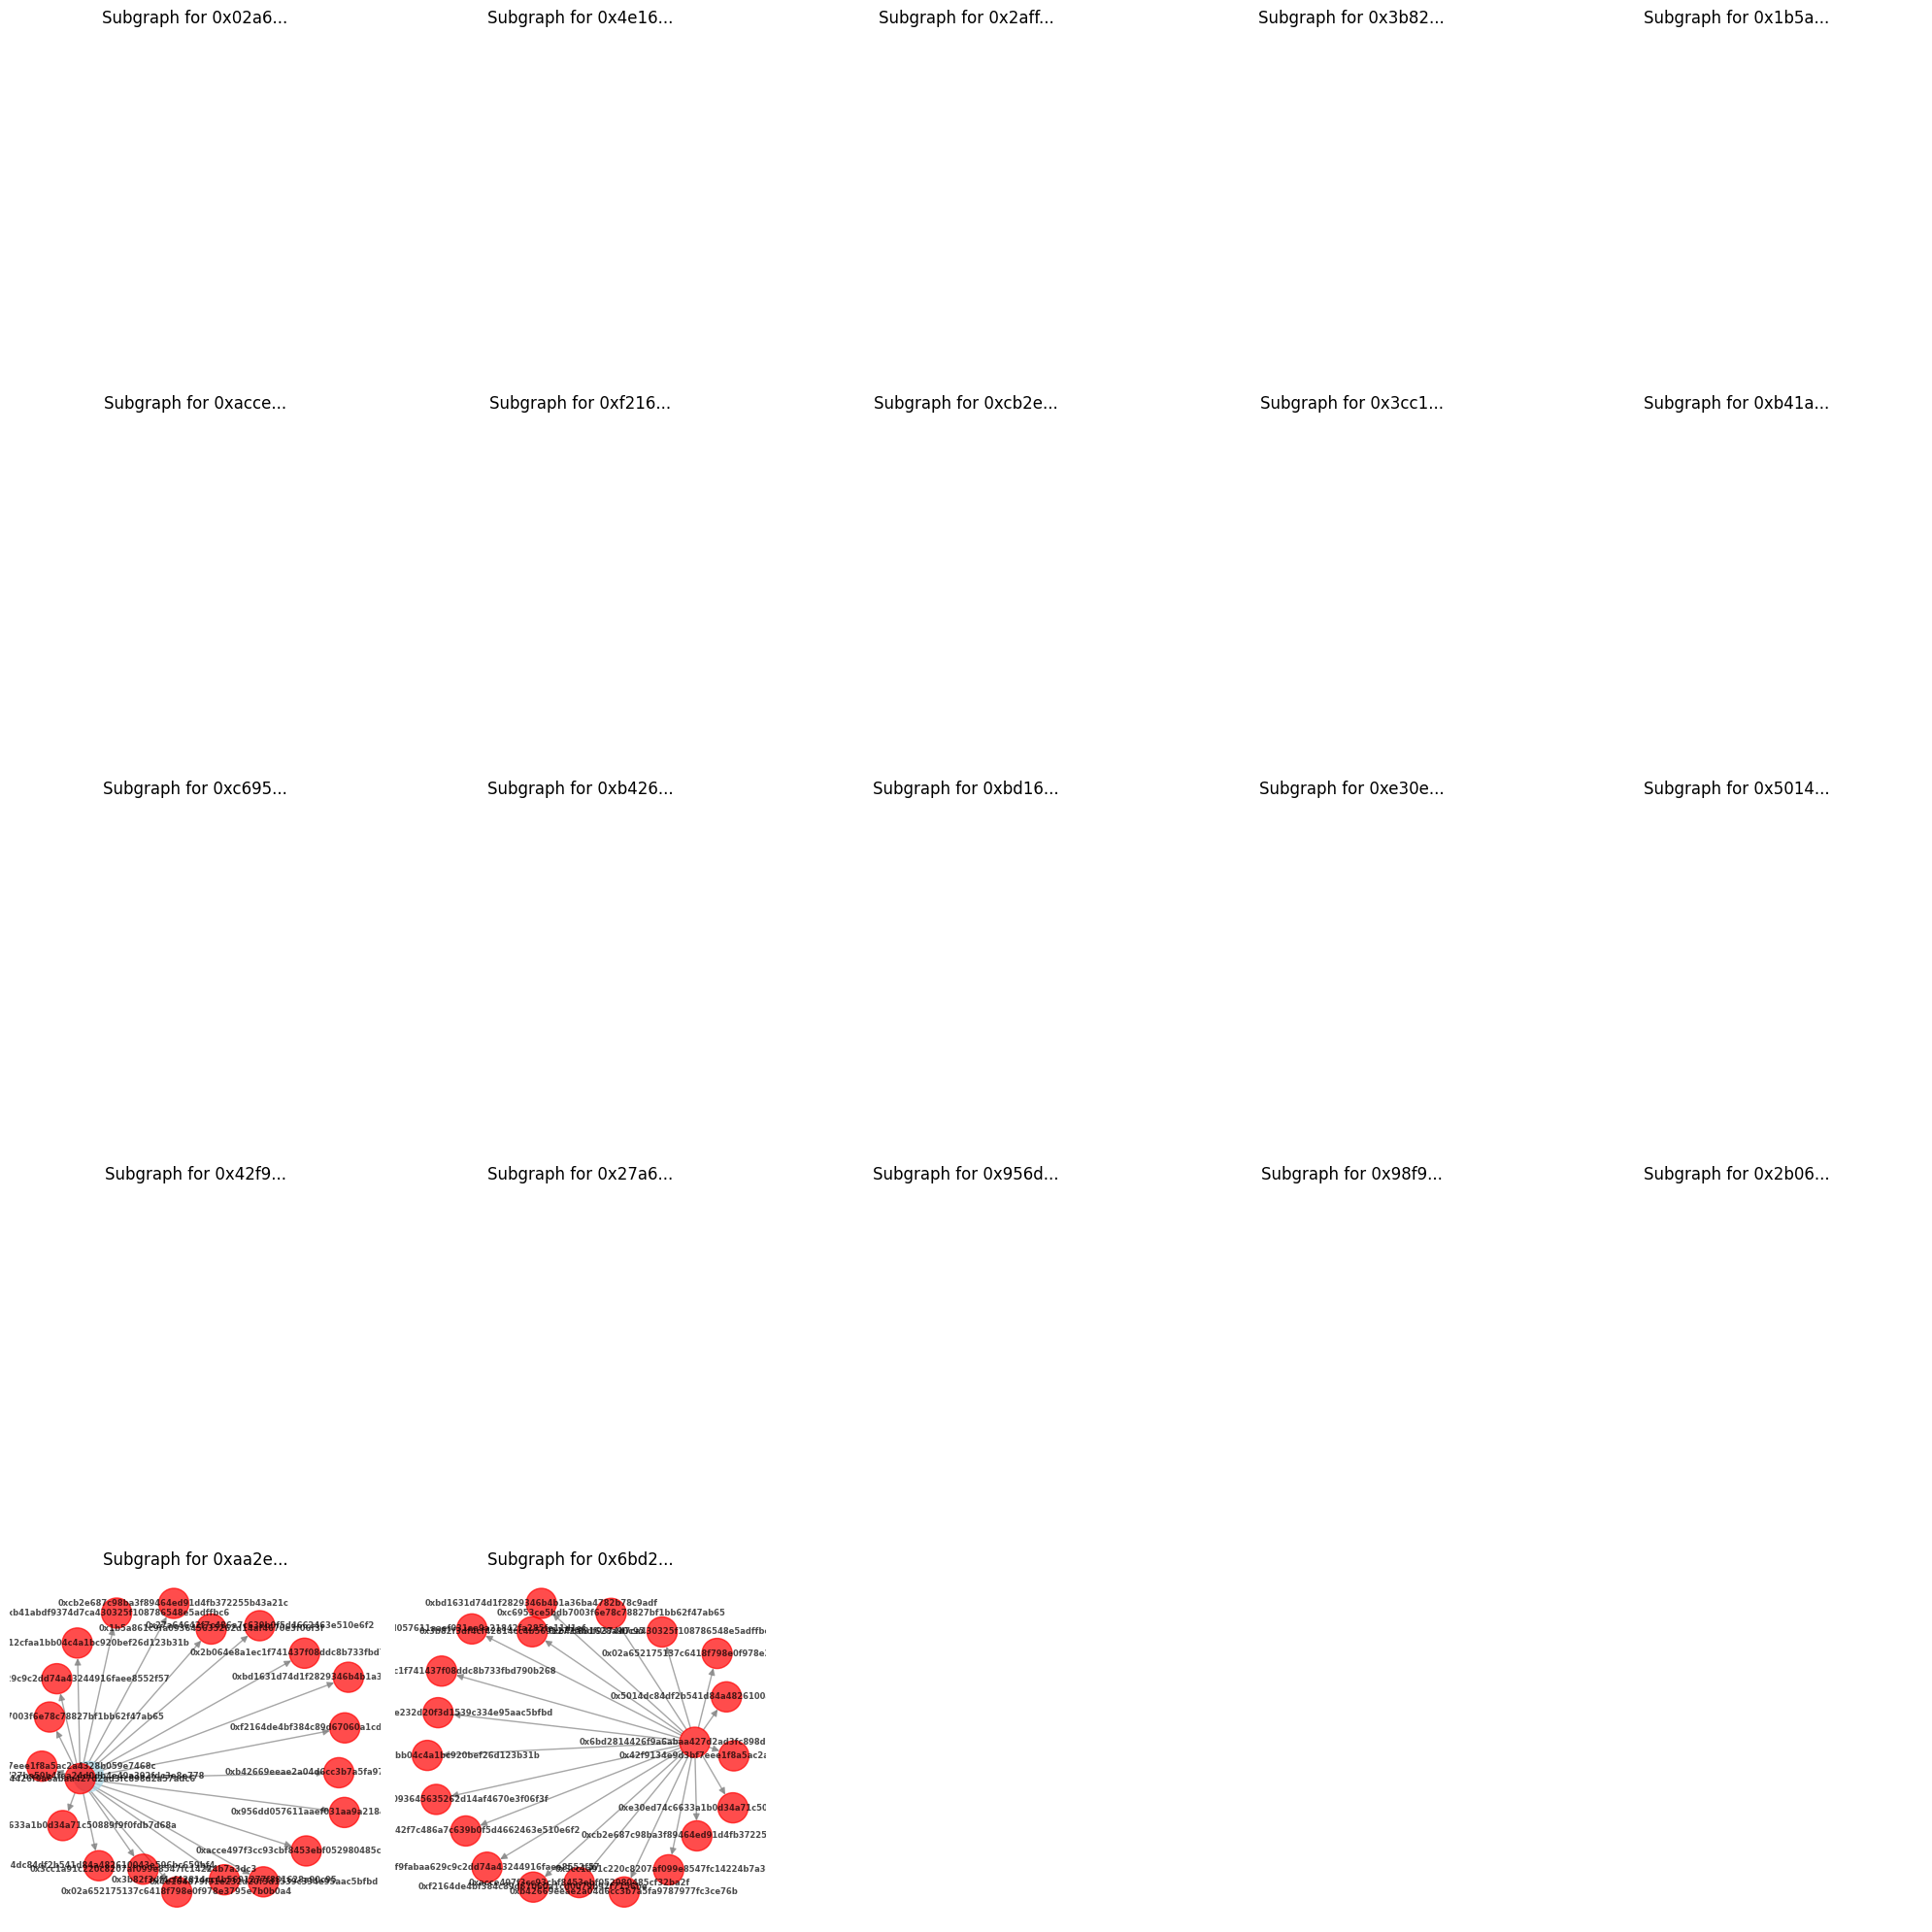

In [10]:
# Re-import necessary libraries and reload the data
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Load the CSV file again
file_path = './ilv.csv'
data = pd.read_csv(file_path)

# Clean the 'Quantity' column
data['Quantity'] = data['Quantity'].str.replace(',', '').astype(float)

# Recreate the set of wallets
wallets = set(data['From']).union(set(data['To']))

# Function to add edges recursively to expand paths
def add_edges_recursive(G, current_wallet, depth, max_depth):
    if depth > max_depth:
        return
    transactions_from_current = data[data['From'] == current_wallet]
    for _, row in transactions_from_current.iterrows():
        to_wallet = row['To']
        quantity = row['Quantity']
        if G.has_edge(current_wallet, to_wallet):
            G[current_wallet][to_wallet]['weight'] += quantity
        else:
            G.add_edge(current_wallet, to_wallet, weight=quantity)
        add_edges_recursive(G, to_wallet, depth + 1, max_depth)

# Step 1: Create subgraphs for each wallet (up to 3 layers deep)
subgraphs = {}
for wallet in wallets:
    subgraph = nx.DiGraph()
    add_edges_recursive(subgraph, wallet, depth=1, max_depth=3)
    subgraphs[wallet] = subgraph

# Step 2: Identify wallets that appear in multiple subgraphs
wallet_occurrences = defaultdict(int)
for subgraph in subgraphs.values():
    for node in subgraph.nodes():
        wallet_occurrences[node] += 1

# Step 3: Assign colors based on occurrences
wallet_colors = {}
for wallet, count in wallet_occurrences.items():
    if count > 1:
        wallet_colors[wallet] = 'red'  # Highlight wallets that appear in multiple subgraphs
    else:
        wallet_colors[wallet] = 'lightblue'  # Default color for others

# Step 4: Visualize the subgraphs
plt.figure(figsize=(20, 20))
num_subgraphs = len(subgraphs)
rows = int((num_subgraphs ** 0.5) + 1)
cols = int((num_subgraphs ** 0.5) + 1)

for i, (wallet, subgraph) in enumerate(subgraphs.items()):
    plt.subplot(rows, cols, i + 1)
    pos = nx.spring_layout(subgraph, seed=42, k=0.3)
    node_colors = [wallet_colors[node] for node in subgraph.nodes()]
    nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color=node_colors, 
            font_size=6, font_weight='bold', arrows=True, edge_color='gray', alpha=0.7)
    plt.title(f"Subgraph for {wallet[:6]}...")

plt.tight_layout()
plt.show()


In [11]:
# Adjusted function to include more layers and a comprehensive connection mapping
def add_full_edges_for_subgraph(G, wallet, depth=3):
    current_layer = {wallet}
    visited = set()

    for _ in range(depth):
        next_layer = set()
        for current_wallet in current_layer:
            if current_wallet not in visited:
                # Outgoing transactions from the wallet
                transactions_from_wallet = data[data['From'] == current_wallet]
                for _, row in transactions_from_wallet.iterrows():
                    to_wallet = row['To']
                    quantity = row['Quantity']
                    G.add_edge(current_wallet, to_wallet, weight=quantity)
                    next_layer.add(to_wallet)

                # Incoming transactions to the wallet
                transactions_to_wallet = data[data['To'] == current_wallet]
                for _, row in transactions_to_wallet.iterrows():
                    from_wallet = row['From']
                    quantity = row['Quantity']
                    G.add_edge(from_wallet, current_wallet, weight=quantity)
                    next_layer.add(from_wallet)
                
                visited.add(current_wallet)
        current_layer = next_layer

# Mega Graph initialization
mega_graph = nx.DiGraph()

# Create subgraphs for each wallet and plot them
for wallet in wallets:
    # Generate subgraph for the wallet
    subgraph = nx.DiGraph()
    subgraph.add_node(wallet)  # Start with the current wallet
    add_full_edges_for_subgraph(subgraph, wallet)
    
    # Add all edges and nodes from the subgraph to the mega graph
    mega_graph.add_edges_from(subgraph.edges(data=True))
    
    # Set positions for subgraph
    pos_subgraph = nx.spring_layout(subgraph, seed=42)
    
    # Draw the subgraph
    plt.figure(figsize=(8, 8))
    nx.draw(subgraph, pos_subgraph, with_labels=True, node_size=700, node_color=[color_map[n] for n in subgraph.nodes()],
            font_size=10, font_weight='bold', arrows=True, edge_color='gray', alpha=0.7)
    subgraph_labels = nx.get_edge_attributes(subgraph, 'weight')
    nx.draw_networkx_edge_labels(subgraph, pos_subgraph, edge_labels=subgraph_labels, font_color='blue', font_size=8)
    
    plt.title(f"Subgraph for Wallet: {wallet}")
    plt.show()

# Draw the Mega Graph
plt.figure(figsize=(20, 20))
pos_mega = nx.spring_layout(mega_graph, seed=42, k=0.2)  # Adjust k for spacing

nx.draw(mega_graph, pos_mega, with_labels=True, node_size=800, node_color=[color_map[n] for n in mega_graph.nodes()],
        font_size=9, font_weight='bold', arrows=True, edge_color='gray', alpha=0.7)
mega_labels = nx.get_edge_attributes(mega_graph, 'weight')
nx.draw_networkx_edge_labels(mega_graph, pos_mega, edge_labels=mega_labels, font_color='red', font_size=7)

plt.title("Mega Graph: All ILV Token Transactions Between Wallets")
plt.show()


NameError: name 'color_map' is not defined